#### Import packages

In [2]:
import pandas as pd #for data management and wrangling
import numpy as np #for calculations and data wrangling
from numpy import random
import matplotlib.pyplot as plt #for graphs
import seaborn as sns #for graphs
import sklearn #for the TF-IDF vectorizer, cosine similarity, etc.
import nltk #for nlp pre-processing
from nltk import word_tokenize
# nltk.download()
import spacy #for nlp pre-processing
import en_core_web_sm  # or any other model you downloaded via spacy download or pip
nlp = en_core_web_sm.load()
from spacy.lang.en import STOP_WORDS
import string
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Enable inline plotting
%matplotlib inline

#### Read in xlsx file

In [200]:
#df = pd.read_csv('ALLDATA_MERGE.csv')
df = pd.read_excel('ALLDATA_MERGE.xlsx')
#df.head()

##### Get list of unique values in the LinkName column

In [5]:
df.LinkName.unique()

array(['Advancing Equity - November 20, 2018 - DHC Employees',
       'Advancing Equity - December 18, 2018 - DHC Employees',
       'Advancing Equity - November 9 2018 - DHC Employees',
       'Aspiring Manager Program, Session 4: Advancing Equity, Diversity & Inclusion - November 9 2018',
       'MDP Track 1 , Session 3: Advancing Equity, Diversity & Inclusion - November 9, 2018',
       'Journey Program: Advancing Equity, Diversity & Inclusion - November 9, 2018',
       'LeadDOE Session1: Advancing Equity, Diversity & Inclusion - November 15, 2018',
       'Advancing Equity – November 15, 2018 – DHC Employees',
       'Journey Program: Advancing Equity, Diversity & Inclusion - November 15,2018',
       'Advancing Equity – November 30, 2018 – DHC Employees',
       'Advancing Equity – December 5, 2018 – DHC Employees',
       'Advancing Equity – December 12, 2018 – DHC Employees',
       'MDP Track 2, Session 3: Advancing Equity, Diversity & Inclusion - December 12, 2018'],
      dt

##### create new column (emp_group) with distinct employee groups based on LinkName values - for easier grouping

In [201]:
conditions = [
    (df['LinkName'] == 'Advancing Equity - November 20, 2018 - DHC Employees') | (df['LinkName'] == 'Advancing Equity - December 18, 2018 - DHC Employees') | (df['LinkName'] == 'Advancing Equity - November 9 2018 - DHC Employees') | (df['LinkName'] == 'Advancing Equity – November 30, 2018 – DHC Employees') | (df['LinkName'] == 'Advancing Equity – December 5, 2018 – DHC Employees') | (df['LinkName'] == 'Advancing Equity – December 12, 2018 – DHC Employees') | (df['LinkName'] == 'Advancing Equity – November 15, 2018 – DHC Employees'),
    (df['LinkName'] == 'Aspiring Manager Program, Session 4: Advancing Equity, Diversity & Inclusion - November 9 2018'),
    (df['LinkName'] == 'MDP Track 1 , Session 3: Advancing Equity, Diversity & Inclusion - November 9, 2018'),
    (df['LinkName'] == 'Journey Program: Advancing Equity, Diversity & Inclusion - November 9, 2018') | (df['LinkName'] == 'Journey Program: Advancing Equity, Diversity & Inclusion - November 15,2018'),
    (df['LinkName'] == 'LeadDOE Session1: Advancing Equity, Diversity & Inclusion - November 15, 2018'),
    (df['LinkName'] == 'MDP Track 2, Session 3: Advancing Equity, Diversity & Inclusion - December 12, 2018')]
choices = ['DHC Employees', 'Aspiring Manager Program', 'MDP Track 1', 'Journey Program', 'LeadDOE', 'MDP Track 2']
df['emp_group'] = np.select(conditions, choices)
#df.head()

In [124]:
df.emp_group.unique()

array(['DHC Employees', 'Aspiring Manager Program', 'MDP Track 1',
       'Journey Program', 'LeadDOE', 'MDP Track 2'], dtype=object)

##### Get word counts for text cols

In [202]:
df['totalwords_takeaway'] = df['Whatwasthemostusefulpieceofinformationorskillthatyoutookawayfrom'].str.split().str.len()
df['totalwords_improvement'] = df['Whatwouldhavemadethesessionmorevaluable\xa0'].str.split().str.len()
#df.head()

#### Analyse helpers

In [163]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [164]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [165]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [166]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [167]:
def wrap_title(title):
    tokens = title.split()
    if len(tokens) > 2:
        tokens.insert(2, "\n")
    return " ".join(tokens)

In [168]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(17, 10), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(2, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        if i == int(len(dfs) /2):
            ax.set_xlabel("Mean TF-IDF Score", labelpad=16, fontsize=14)
        ax.set_title(wrap_title(str(df.label)))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

#### Analyse takeaway

##### Get tokens, lemmas, and pos tags for the key takeaways text

In [203]:
tokens = []
lemma = []
pos = []

for doc in nlp.pipe(df['Whatwasthemostusefulpieceofinformationorskillthatyoutookawayfrom'].astype('unicode').values, batch_size=30,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

df['tokens_takeaway'] = tokens
df['lemmas_takeaway'] = lemma
df['pos_takeaway'] = pos

#df.head()

In [170]:
df['lemmas_takeaway'] = df['lemmas_takeaway'].apply(lambda x: [t for t in x if t != "-PRON-"])


In [171]:
df['lemmas_takeaway'] = df['lemmas_takeaway'].apply(lambda x: [t for t in x if t != "the"])

In [172]:
df['lemmas_takeaway'] = df['lemmas_takeaway'].apply(lambda x: [t for t in x if t != "like"])

In [173]:
df['lemmas_takeaway'] = df['lemmas_takeaway'].apply(lambda x: [t for t in x if t != "not"])

##### Create new df with just groups, word counts, and lemmas

In [174]:
takeaway = df[['emp_group',
'totalwords_takeaway',
 'lemmas_takeaway']]
takeaway.head()

,emp_group,totalwords_takeaway,lemmas_takeaway
0,DHC Employees,NaN,[nan]
1,DHC Employees,22.0,"[understand, multiple, layer, bias, exist, giv..."
2,DHC Employees,55.0,"[as, black, woman, live, consequence, implicit..."
3,DHC Employees,37.0,"[think, d.i.v.e., usually, jump, evaluate, try..."
4,DHC Employees,23.0,"[1, understand, nuance, interconnection, bias,..."


##### drop na values

In [175]:
takeaway = takeaway.dropna(how='any')
takeaway.head()

,emp_group,totalwords_takeaway,lemmas_takeaway
1,DHC Employees,22.0,"[understand, multiple, layer, bias, exist, giv..."
2,DHC Employees,55.0,"[as, black, woman, live, consequence, implicit..."
3,DHC Employees,37.0,"[think, d.i.v.e., usually, jump, evaluate, try..."
4,DHC Employees,23.0,"[1, understand, nuance, interconnection, bias,..."
7,DHC Employees,58.0,"[nyu, facilitator, amazing, moment, learn, hap..."


In [176]:
takeaway.emp_group.unique()

array(['DHC Employees', 'Aspiring Manager Program', 'MDP Track 1',
       'Journey Program', 'LeadDOE', 'MDP Track 2'], dtype=object)

##### Make a tfidf function

In [177]:
vect = sklearn.feature_extraction.text.TfidfVectorizer(max_features=11)

##### Apply tfidf function

In [178]:
lemmas = takeaway['lemmas_takeaway'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [179]:
takeaway['all'] = 'all'

##### Visualize

In [180]:
dfs = top_feats_by_class(features, takeaway['emp_group'], feature_names)

In [181]:
df_all = top_feats_by_class(features, takeaway['all'], feature_names)

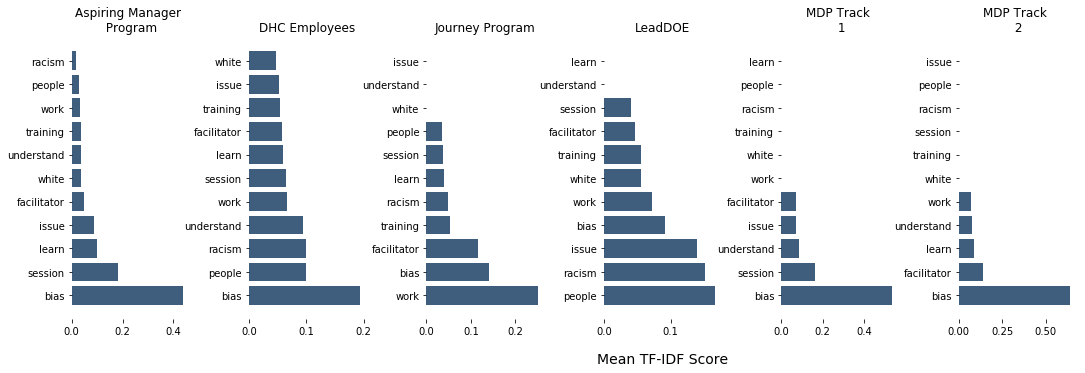

In [182]:
plot_tfidf_classfeats_h(dfs)

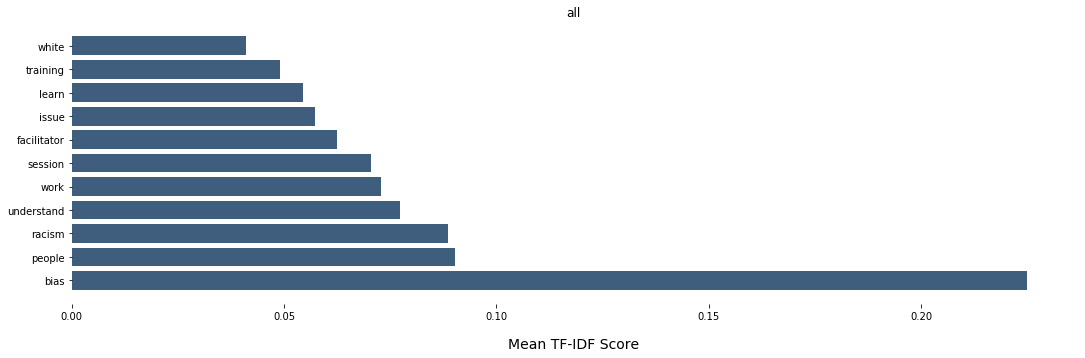

In [183]:
plot_tfidf_classfeats_h(df_all)

##### kmeans

In [184]:
X = vect.fit_transform(takeaway['lemmas_takeaway'].apply(lambda x: ' '.join(x)))

true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 people
 facilitator
 issue
 session
 learn
 bias
 work
 white
 racism
 training
Cluster 1:
 bias
 session
 facilitator
 learn
 people
 understand
 work
 white
 training
 racism
Cluster 2:
 racism
 bias
 issue
 understand
 work
 training
 white
 session
 people
 learn
Cluster 3:
 training
 work
 session
 bias
 learn
 facilitator
 racism
 people
 white
 issue
Cluster 4:
 understand
 work
 bias
 people
 racism
 issue
 session
 learn
 training
 facilitator
Cluster 5:
 white
 people
 racism
 bias
 learn
 training
 session
 work
 facilitator
 understand


#### Analyse improvement

##### Get tokens, lemmas, and pos tags for the improvement suggestions text

In [204]:
tokens = []
lemma = []
pos = []

for doc in nlp.pipe(df['Whatwouldhavemadethesessionmorevaluable\xa0'].astype('unicode').values, batch_size=30,
                        n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc if not n.is_punct and not n.is_stop and not n.is_space])
        lemma.append([n.lemma_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space])
        pos.append([n.pos_ for n in doc if not n.is_punct and not n.is_stop and not n.is_space])
    else:
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

df['tokens_improvement'] = tokens
df['lemmas_improvement'] = lemma
df['pos_improvement'] = pos

#df.head()

In [186]:
df['lemmas_improvement'] = df['lemmas_improvement'].apply(lambda x: [t for t in x if t != "-PRON-"])

In [187]:
df['lemmas_improvement'] = df['lemmas_improvement'].apply(lambda x: [t for t in x if t != "like"])

In [188]:
df['lemmas_improvement'] = df['lemmas_improvement'].apply(lambda x: [t for t in x if t != "the"])

In [189]:
df['lemmas_improvement'] = df['lemmas_improvement'].apply(lambda x: [t for t in x if t != "not"])

##### Create new df with just groups, word counts, and lemmas

In [190]:
improvement = df[['emp_group',
'totalwords_improvement',
 'lemmas_improvement']]
improvement.head()

,emp_group,totalwords_improvement,lemmas_improvement
0,DHC Employees,NaN,[nan]
1,DHC Employees,NaN,[nan]
2,DHC Employees,75.0,"[session, clear, implicit, bias, what, say, bi..."
3,DHC Employees,4.0,"[strategy, approach, boss, superior]"
4,DHC Employees,27.0,"[1, spend, time, learn, explore, concept, type..."


##### drop na values

In [191]:
improvement = improvement.dropna(how='any')
improvement.head()

,emp_group,totalwords_improvement,lemmas_improvement
2,DHC Employees,75.0,"[session, clear, implicit, bias, what, say, bi..."
3,DHC Employees,4.0,"[strategy, approach, boss, superior]"
4,DHC Employees,27.0,"[1, spend, time, learn, explore, concept, type..."
7,DHC Employees,53.0,"[session, predominantly, people, color, desire..."
8,DHC Employees,28.0,"[feel, majority, participant, open, discussion..."


##### Make a tfidf function

In [192]:
vect = sklearn.feature_extraction.text.TfidfVectorizer(max_features=11)

##### Apply tfidf function

In [193]:
lemmas = improvement['lemmas_improvement'].apply(lambda x: ' '.join(x))
features = vect.fit_transform(lemmas)

feature_names = vect.get_feature_names()
dense = features.todense()
denselist = dense.tolist()

In [194]:
improvement['all'] = 'all'

In [195]:
dfs = top_feats_by_class(features, improvement['emp_group'], feature_names)

In [196]:
df_all = top_feats_by_class(features, improvement['all'], feature_names)

##### Visualize TF-IDF

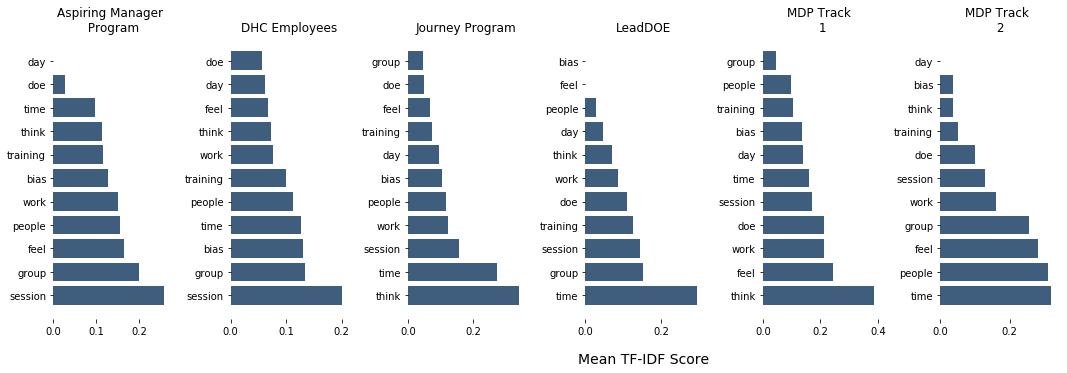

In [197]:
plot_tfidf_classfeats_h(dfs)

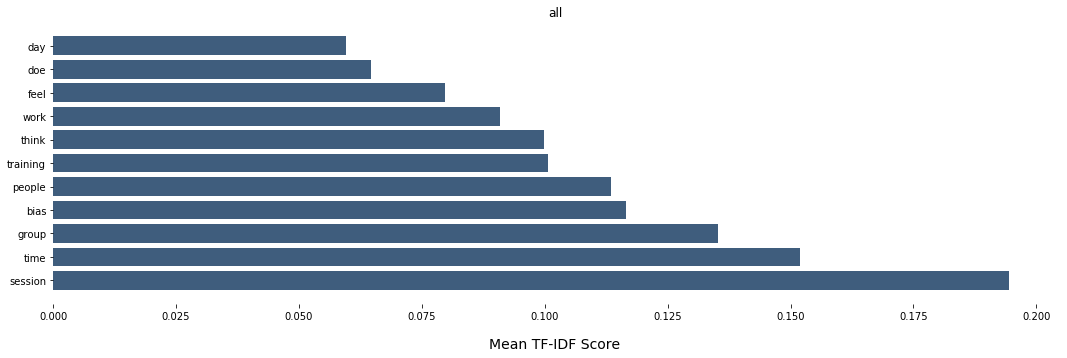

In [198]:
plot_tfidf_classfeats_h(df_all)

##### kmeans

In [199]:
X = vect.fit_transform(improvement['lemmas_improvement'].apply(lambda x: ' '.join(x)))

true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 people
 session
 work
 think
 bias
 doe
 training
 time
 group
 day
Cluster 1:
 feel
 time
 training
 work
 session
 day
 doe
 bias
 group
 think
Cluster 2:
 group
 session
 time
 work
 bias
 think
 doe
 training
 people
 feel
Cluster 3:
 training
 bias
 think
 work
 day
 doe
 session
 time
 people
 group
Cluster 4:
 time
 session
 think
 work
 day
 doe
 bias
 feel
 group
 people
Cluster 5:
 session
 bias
 training
 think
 day
 time
 doe
 feel
 people
 group
